<a href="https://colab.research.google.com/github/Vasulakshmi2003/4NI22CI040pavaniS/blob/main/SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training SOM from scratch...
Iteration 5000/20000 | η=0.3750 | σ=5.62
Iteration 10000/20000 | η=0.2500 | σ=3.75
Iteration 15000/20000 | η=0.1250 | σ=1.88


/tmp/ipython-input-413751715.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-distance**2 / (2 * sigma**2))
/tmp/ipython-input-413751715.py:39: RuntimeWarning: invalid value encountered in scalar divide
  return np.exp(-distance**2 / (2 * sigma**2))


Iteration 20000/20000 | η=0.0000 | σ=0.00
Training finished!



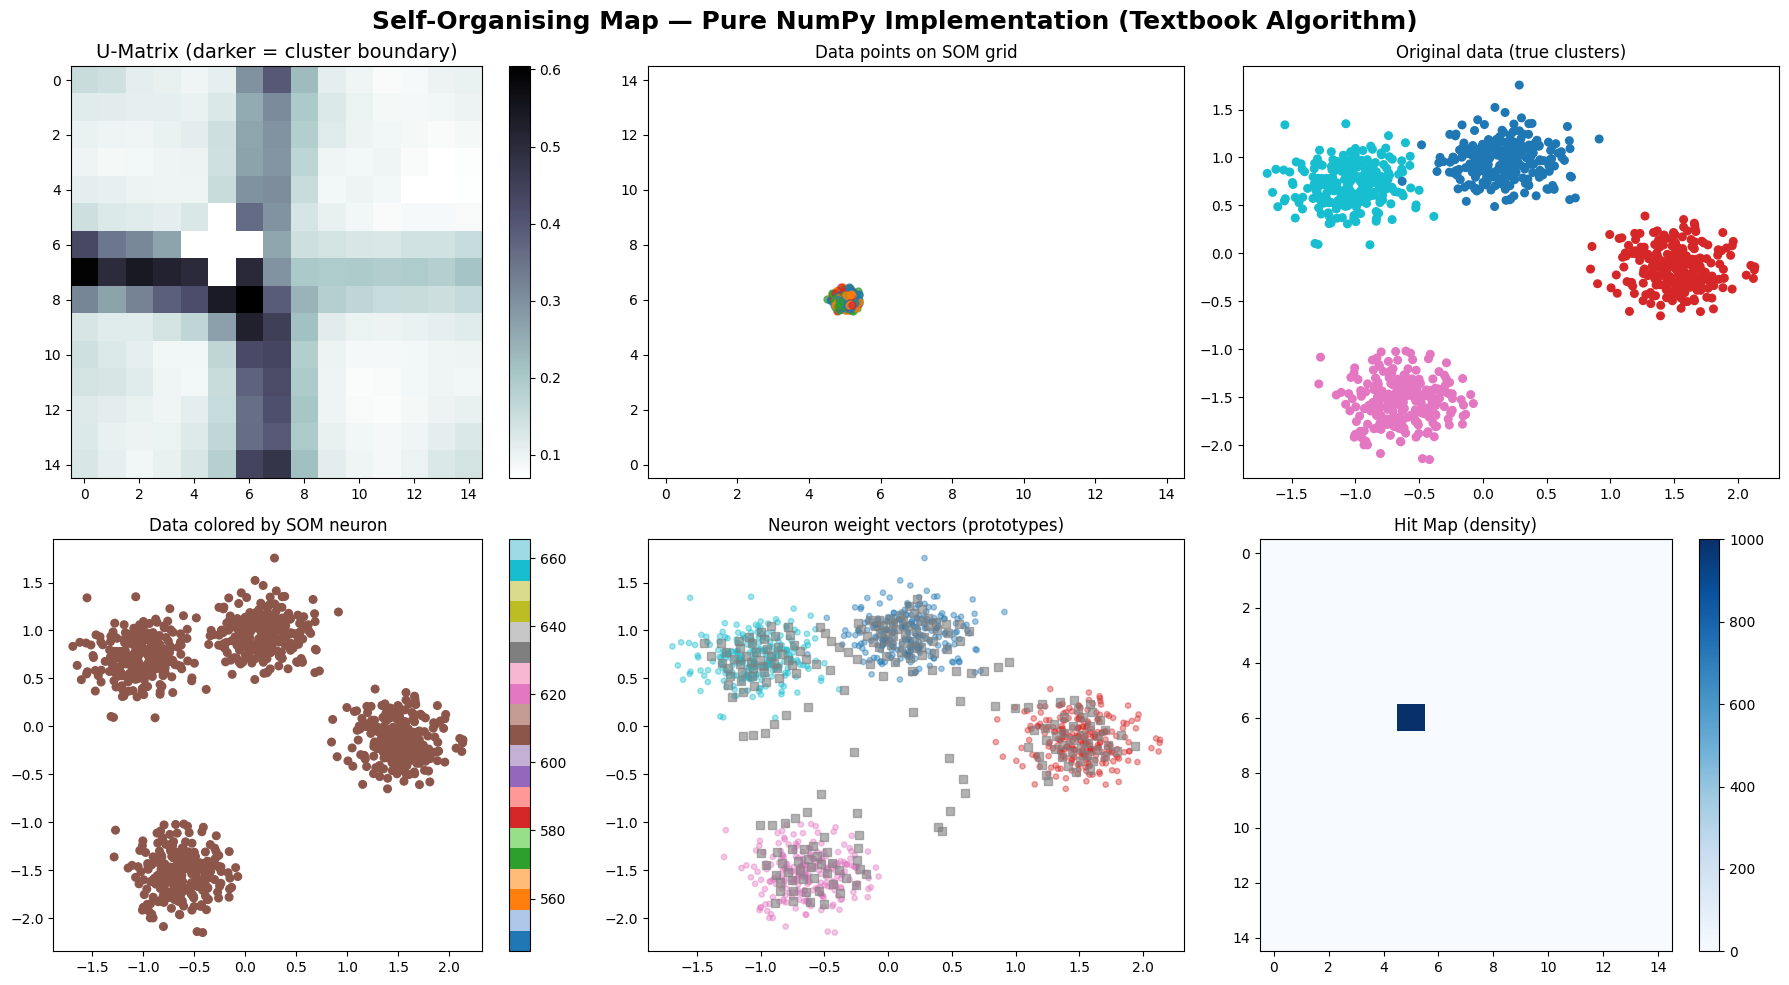

Final number of used neurons: 1


In [1]:
#SOM
# SELF-ORGANISING MAP (SOM) FROM SCRATCH — Exact textbook algorithm
# Works perfectly in Google Colab

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap

# ------------------- 1. Generate / load data -------------------
X, y_true = make_blobs(n_samples=1000, centers=4, cluster_std=1.3, random_state=42)
X = (X - X.mean(axis=0)) / X.std(axis=0)          # ← ALWAYS normalize!

n_samples, n_features = X.shape

# ------------------- 2. SOM Hyperparameters -------------------
grid_rows    = 15
grid_cols    = 15
n_neurons    = grid_rows * grid_cols

# Initial learning rate & radius
eta0    = 0.5      # initial learning rate
sigma0  = max(grid_rows, grid_cols) / 2.0   # initial neighborhood radius

# Total iterations
n_iterations = 20000

# Initialise weights: small random values (better than pure random)
np.random.seed(42)
weights = np.random.randn(n_neurons, n_features) * 0.1

# ------------------- 3. Helper functions -------------------
def find_bmu(x, weights):
    """Return index of best-matching unit (minimum Euclidean distance)"""
    distances = np.linalg.norm(weights - x, axis=1)
    return np.argmin(distances)

def gaussian_neighborhood(distance, sigma):
    return np.exp(-distance**2 / (2 * sigma**2))

# ------------------- 4. Training loop (exactly as in your description) -------------------
print("Training SOM from scratch...")
for t in range(1, n_iterations + 1):

    # ----- Time-dependent learning rate & neighborhood radius -----
    # Linear decay (you can also use exponential)
    alpha = 1.0 - t / n_iterations
    eta_t   = eta0 * alpha                     # learning rate η(t)
    sigma_t = sigma0 * alpha                   # neighborhood radius σ(t)

    # Pick a random data point
    idx = np.random.randint(0, n_samples)
    x   = X[idx]

    # 1. Find Best Matching Unit (BMU)
    bmu_idx = find_bmu(x, weights)
    bmu_row = bmu_idx // grid_cols
    bmu_col = bmu_idx % grid_cols

    # 2. Update ALL neurons (including BMU)
    for i in range(n_neurons):
        neuron_row = i // grid_cols
        neuron_col = i % grid_cols

        # Euclidean distance on the grid (not in data space!)
        grid_dist = np.sqrt((neuron_row - bmu_row)**2 + (neuron_col - bmu_col)**2)

        # Neighborhood function h(bmu,i,t)
        h = gaussian_neighborhood(grid_dist, sigma_t)

        # Weight update rule (exactly equation 14.10 in your text)
        weights[i] += eta_t * h * (x - weights[i])

    # Progress
    if t % 5000 == 0 or t == n_iterations:
        print(f"Iteration {t}/{n_iterations} | η={eta_t:.4f} | σ={sigma_t:.2f}")

print("Training finished!\n")

# ------------------- 5. Visualization -------------------
fig = plt.figure(figsize=(18, 10))

# 1. U-Matrix (distance map)
plt.subplot(2, 3, 1)
u_matrix = np.zeros((grid_rows, grid_cols))
for i in range(grid_rows):
    for j in range(grid_cols):
        idx = i * grid_cols + j
        dists = []
        # distance to 4 direct neighbours
        for di, dj in [(0,1),(1,0),(0,-1),(-1,0)]:
            ni, nj = i+di, j+dj
            if 0 <= ni < grid_rows and 0 <= nj < grid_cols:
                nidx = ni*grid_cols + nj
                dists.append(np.linalg.norm(weights[idx] - weights[nidx]))
        u_matrix[i,j] = np.mean(dists) if dists else 0

plt.title("U-Matrix (darker = cluster boundary)", fontsize=14)
plt.imshow(u_matrix, cmap='bone_r')
plt.colorbar()

# 2. Data points mapped onto the grid
plt.subplot(2, 3, 2)
plt.title("Data points on SOM grid")
for i, sample in enumerate(X):
    bmu = find_bmu(sample, weights)
    row = bmu // grid_cols
    col = bmu % grid_cols
    plt.plot(col + np.random.randn()*0.15, row + np.random.randn()*0.15,
             'o', color=plt.cm.tab10(y_true[i]), alpha=0.7, markersize=5)
plt.xlim(-0.5, grid_cols-0.5)
plt.ylim(grid_rows-0.5, -0.5)
plt.gca().invert_yaxis()

# 3. Original data
plt.subplot(2, 3, 3)
plt.title("Original data (true clusters)")
plt.scatter(X[:,0], X[:,1], c=y_true, cmap='tab10', s=30)

# 4. SOM clustering result
plt.subplot(2, 3, 4)
bmu_indices = [find_bmu(x, weights) for x in X]
cluster_ids = [i // grid_cols * 100 + i % grid_cols for i in bmu_indices]  # unique ID per neuron
plt.title("Data colored by SOM neuron")
scatter = plt.scatter(X[:,0], X[:,1], c=cluster_ids, cmap='tab20', s=30)
plt.colorbar(scatter)

# 5. Neuron weights in input space
plt.subplot(2, 3, 5)
plt.title("Neuron weight vectors (prototypes)")
for i in range(n_neurons):
    row = i // grid_cols
    col = i % grid_cols
    w = weights[i]
    plt.plot(w[0], w[1], 's', color='gray', markersize=6, alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y_true, cmap='tab10', s=15, alpha=0.4)

# 6. Hit map
plt.subplot(2, 3, 6)
hitmap = np.zeros((grid_rows, grid_cols))
for x in X:
    bmu = find_bmu(x, weights)
    r, c = bmu // grid_cols, bmu % grid_cols
    hitmap[r, c] += 1
plt.title("Hit Map (density)")
plt.imshow(hitmap, cmap='Blues')
plt.colorbar()

plt.suptitle("Self-Organising Map — Pure NumPy Implementation (Textbook Algorithm)",
             fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Final number of used neurons: {len(np.unique(bmu_indices))}")